In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
import scanpy as sc
from scipy import stats
import pickle
import scanorama
from sklearn.model_selection import train_test_split

config = {
    # Device
    "processor": "Other",  # 'Other' or 'M' - M is for Mac M1/M2/M3 processors
    # 'Data':
    "file": "fly_train.h5ad",  # name of the data file
    "eval_file": "fly_eval.h5ad",  # name of the data file for final evaluation
    "original_file": "fly_original.h5ad",  # name of the original data file
    "batch_file": "fly_train_batch.h5ad",  # name of the batch corrected data file
    "batch_eval_file": "fly_eval_batch.h5ad",  # name of the batch corrected data file for final evaluation
    "batch_original_file": "fly_original_batch.h5ad",  # name of the original data file
    "tissue": "head",  # 'head' or 'body'
    "model_type": "cnn",  # 'CNN' or 'MLP' or 'XGBoost' or 'random_forest' or logistic_regression'
    "encoding_variable": "age",  # variable to use for encoding - (sex_age), (sex), or (age)
    "batch_correction": False,  # True to perform batch correction, False to skip, (ONLY FOR AGE ENCODING)
    "select_batch_genes": "yes",  # True to select batch genes, False to skip, (ONLY FOR AGE ENCODING)
}

In [5]:
# Given your imports and path setup
Code_dir = os.getcwd()
Data_dir = os.path.join(Code_dir, "Data", "h5ad", config["tissue"])

# Path to the h5ad file
h5ad_file_path = os.path.join(Data_dir, "uncorrected", config["file"])
h5ad_eval_file_path = os.path.join(Data_dir, "uncorrected", config["eval_file"])
h5ad_file_path_original = os.path.join(Data_dir, "uncorrected", config["original_file"])

# Load the file
adata = sc.read_h5ad(h5ad_file_path)
adata_eval = sc.read_h5ad(h5ad_eval_file_path)
adata_original = sc.read_h5ad(h5ad_file_path_original)

# Path to the batch corrected h5ad file
h5ad_file_path_corrected = os.path.join(
    Data_dir, "batch_corrected", config["batch_file"]
)
h5ad_eval_file_path_corrected = os.path.join(
    Data_dir, "batch_corrected", config["batch_eval_file"]
)
h5ad_file_path_original_corrected = os.path.join(
    Data_dir, "batch_corrected", config["batch_original_file"]
)

# Load the batch corrected file
adata_corrected = sc.read_h5ad(h5ad_file_path_corrected)
adata_eval_corrected = sc.read_h5ad(h5ad_eval_file_path_corrected)
# adata_original_corrected = sc.read_h5ad(h5ad_file_path_original_corrected)

In [15]:
# Print all column names in adata.obs
print("Column names in adata.obs:", adata.obs.columns.tolist())

Column names in adata.obs: ['tissue', 'sex', 'age', 'sex_age', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_mt', 'dataset', 'fca_annotation', 'afca_annotation', 'afca_annotation_broad']


In [21]:
# Print all unique cell types in the specified column of adata.obs
cell_types = adata.obs["afca_annotation_broad"].unique()
print("Unique cell types:", cell_types)
# Specify the cell type you're interested in
specific_cell_type = "CNS neuron"

# Count the number of cells for the specified cell type
cell_count = (adata.obs["afca_annotation_broad"] == specific_cell_type).sum()
print(f"Total number of cells in {specific_cell_type}: {cell_count}")

Unique cell types: ['CNS neuron', 'glial cell', 'epithelial cell', 'sensory neuron', 'hemocyte', ..., 'cardial cell', 'somatic precursor cell', 'male reproductive system', 'female germline cell', 'gland']
Length: 16
Categories (16, object): ['CNS neuron', 'cardial cell', 'epithelial cell', 'excretory system', ..., 'muscle cell', 'sensory neuron', 'somatic precursor cell', 'tracheal cell']
Total number of cells in CNS neuron: 162023


In [8]:
# Path to your pickle file
file_path = os.path.join(
    Code_dir,
    "Data",
    "uncorrected",
    "head",
    "CNN",
    "age",
    "full_data",
    "celltype_all",
    "sextype_all",
    "highly_variable_genes.pkl",
)

# Load the pickle file
with open(file_path, "rb") as file:
    data = pickle.load(file)

# Inspect the contents
print(data)  # Print the content (if not too large)

['128up', '18w', '28SrRNA-Psi:CR40596', '5-HT1A', '5-HT2A', '5-HT2B', '5-HT7', 'AANAT1', 'AANATL2', 'ACXB', 'ACXC', 'ACXD', 'AGBE', 'AGO3', 'AIMP3', 'AOX1', 'AOX3', 'AOX4', 'AP-2sigma', 'AQP', 'ARY', 'ASPP', 'ATP7', 'ATPsynepsilonL', 'Aatf', 'Abd-B', 'Ac13E', 'Ac78C', 'Acbp1', 'Acbp2', 'Acbp3', 'Acbp5', 'Achl', 'Acox57D-d', 'Acox57D-p', 'Acp1', 'Acp36DE', 'Acp63F', 'Acp65Aa', 'Act42A', 'Act57B', 'Act79B', 'Act87E', 'Act88F', 'Actn', 'Acyp2', 'AdamTS-A', 'AdamTS-B', 'Adgf-A', 'Adgf-A2', 'Adgf-C', 'Adgf-D', 'Adgf-E', 'Adh', 'Adi1', 'AdoR', 'Ae2', 'AgmNAT', 'Agpat2', 'Agpat4', 'Ahcy', 'AhcyL2', 'Akh', 'AkhR', 'Akr1B', 'Alas', 'Aldh', 'Alg14', 'Alp4', 'Alp6', 'Alp9', 'Ama', 'Amph', 'Amt', 'Amy-p', 'Ance', 'Ance-3', 'Antp', 'AnxB10', 'AnxB9', 'Apc2', 'Apoltp', 'Arc1', 'Arc2', 'Arc42', 'Arfrp1', 'Arl1', 'Arl6', 'Arp5', 'Arpc2', 'Arpc3B', 'Arpc4', 'Arpc5', 'Arr1', 'Arr2', 'Art1', 'AsnS', 'Asph', 'AstA', 'AstA-R1', 'AstA-R2', 'AstC', 'AstC-R1', 'AstC-R2', 'AstCC', 'Atac1', 'Atf-2', 'Atf3', 'At

In [6]:
# Decision for dataset based on batch_correction
dataset_to_use = adata_corrected if config["batch_correction"] else adata

# Perform a stratified train-test split based on encoding variable
train_subset, test_subset = train_test_split(
    dataset_to_use,
    stratify=dataset_to_use.obs[config["encoding_variable"]],
    test_size=0.2,
    random_state=42,
)

if config["select_batch_genes"].lower() == "yes" and not config["batch_correction"]:
    # Apply gene selection from corrected data if specified and not already using corrected data
    train_subset = train_subset[:, adata_corrected.var_names]
    test_subset = test_subset[:, adata_corrected.var_names]

In [14]:
var_names = pd.DataFrame(train_subset.X.todense(), columns=train_subset.var_names)
train_subset.obs = train_subset.obs.reset_index(drop=False)
var_names["sex"] = train_subset.obs["sex"]
var_names["age"] = train_subset.obs["age"]

# Corrected list of top genes
corrected_top_genes = [
    "IncRNA:roX1",
    "IncRNA:roX2",
    "IncRNA:noe",
    "unc-13",
    "IncRA:CR34335",
    "Ank2",
    "Hsp83",
    "Sh",
    "CG4467",
    "pan",
    "CG17684",
    "ninaE",
    "rdgA",
    "nrv3",
    "IncRA:CR43836",
    "CG10077",
    "IncRNA:Hsromega",
    "Syt1",
    "Pdp1",
    "CG41378",
]

# Find columns in the DataFrame that closely match the genes in the corrected_top_genes list
matched_genes_corrected = {}
for gene in corrected_top_genes:
    # Split the gene by ":" and get the last element to find potential matches
    gene_part = gene.split(":")[-1]
    potential_matches = [col for col in var_names.columns if gene_part in col]
    if potential_matches:
        matched_genes_corrected[gene] = potential_matches[0]
    else:
        matched_genes_corrected[gene] = None

matched_genes_corrected

{'IncRNA:roX1': None,
 'IncRNA:roX2': 'lncRNA:roX2',
 'IncRNA:noe': 'lncRNA:noe',
 'unc-13': 'unc-13-4A',
 'IncRA:CR34335': 'lncRNA:CR34335',
 'Ank2': None,
 'Hsp83': 'Hsp83',
 'Sh': 'Shark',
 'CG4467': 'CG4467',
 'pan': None,
 'CG17684': None,
 'ninaE': 'ninaE',
 'rdgA': 'rdgA',
 'nrv3': None,
 'IncRA:CR43836': 'lncRNA:CR43836',
 'CG10077': None,
 'IncRNA:Hsromega': 'lncRNA:Hsromega',
 'Syt1': None,
 'Pdp1': None,
 'CG41378': None}

In [14]:
df_expression = pd.DataFrame(adata_batch.X.todense(), columns=adata_batch.var_names)
adata_batch.obs = adata_batch.obs.reset_index(drop=False)
df_expression["sex"] = adata_batch.obs["sex"]
df_expression["age"] = adata_batch.obs["age"]

# Corrected list of top genes
corrected_top_genes = [
    "IncRNA:roX1",
    "IncRNA:roX2",
    "IncRNA:noe",
    "unc-13",
    "IncRA:CR34335",
    "Ank2",
    "Hsp83",
    "Sh",
    "CG4467",
    "pan",
    "CG17684",
    "ninaE",
    "rdgA",
    "nrv3",
    "IncRA:CR43836",
    "CG10077",
    "IncRNA:Hsromega",
    "Syt1",
    "Pdp1",
    "CG41378",
]

# Find columns in the DataFrame that closely match the genes in the corrected_top_genes list
matched_genes_corrected = {}
for gene in corrected_top_genes:
    # Split the gene by ":" and get the last element to find potential matches
    gene_part = gene.split(":")[-1]
    potential_matches = [col for col in df_expression.columns if gene_part in col]
    if potential_matches:
        matched_genes_corrected[gene] = potential_matches[0]
    else:
        matched_genes_corrected[gene] = None

matched_genes_corrected

{'IncRNA:roX1': None,
 'IncRNA:roX2': 'lncRNA:roX2',
 'IncRNA:noe': 'lncRNA:noe',
 'unc-13': 'unc-13-4A',
 'IncRA:CR34335': 'lncRNA:CR34335',
 'Ank2': None,
 'Hsp83': 'Hsp83',
 'Sh': 'Shark',
 'CG4467': 'CG4467',
 'pan': None,
 'CG17684': None,
 'ninaE': 'ninaE',
 'rdgA': 'rdgA',
 'nrv3': None,
 'IncRA:CR43836': 'lncRNA:CR43836',
 'CG10077': None,
 'IncRNA:Hsromega': 'lncRNA:Hsromega',
 'Syt1': None,
 'Pdp1': None,
 'CG41378': None}

In [13]:
"18w" in adata_batch.var_names

True

computing PCA
    with n_comps=600
    finished (0:03:45)


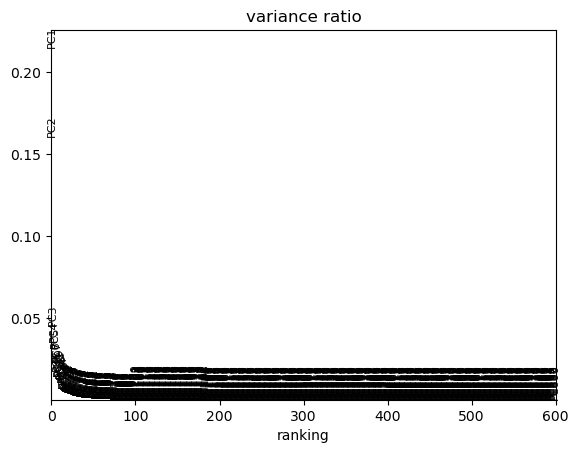

Total variance explained by the first  PCs: 85.74%


In [15]:
# Preprocess the data
adata_vis = adata_batch.copy()

# Preprocess the copy for visualization
sc.pp.pca(adata_vis, n_comps=600)
sc.pl.pca_variance_ratio(adata_vis, n_pcs=600, log=False)

total_variance_explained = sum(adata_vis.uns["pca"]["variance_ratio"][:200])
print(
    f"Total variance explained by the first  PCs: {total_variance_explained*100:.2f}%"
)

In [3]:
adata_vis = adata_batch.copy()
sc.settings.verbosity = 2
sc.pp.pca(adata_vis, n_comps=200)
sc.pp.neighbors(adata_vis, n_pcs=200)  # Compute the neighborhood graph
sc.tl.umap(adata_vis)
sc.pl.umap(
    adata_vis, color="age", title="after Batch Correction", save="after-correction.png"
)

computing PCA
    with n_comps=200


In [ ]:
adata_list_by_age = [
    adata[adata.obs["age"] == age].copy() for age in adata.obs["age"].unique()
]
corrected_adatas = scanorama.correct_scanpy(adata_list_by_age)
corrected_adata = corrected_adatas[0].concatenate(corrected_adatas[1:], batch_key="age")

In [ ]:
sc.pp.pca(corrected_adata, n_comps=600)  # Perform PCA to reduce to 50 components
sc.pl.pca_variance_ratio(corrected_adata, n_pcs=600, log=False)

total_variance_explained = sum(corrected_adata.uns["pca"]["variance_ratio"][:600])
print(
    f"Total variance explained by the first  PCs: {total_variance_explained*100:.2f}%"
)

In [ ]:
adata_vis = corrected_adata.copy()
sc.settings.verbosity = 2
# sc.pp.pca(adata_vis, n_comps=?)
# sc.pp.neighbors(adata_vis, n_pcs=?)  # Compute the neighborhood graph
sc.tl.umap(adata_vis)
sc.pl.umap(
    adata_vis, color="age", title="After Batch Correction", save="after-correction.png"
)

In [ ]:
# Reading genes from both CSV files
autosomal_genes = (
    pd.read_csv(os.path.join(Data_dir, "..", "autosomal.csv"), header=None, dtype=str)
    .iloc[:, 0]
    .tolist()
)
sex_genes = (
    pd.read_csv(os.path.join(Data_dir, "..", "sex.csv"), header=None)
    .iloc[:, 0]
    .tolist()
)

autosomal_mask = adata.var.index.isin(autosomal_genes)
sex_mask = adata.var.index.isin(sex_genes)

# Inverting the masks
not_autosomal_mask = ~autosomal_mask
not_sex_mask = ~sex_mask
combined_mask = not_autosomal_mask & not_sex_mask
genes_not_in_either = adata.var.index[combined_mask]
len(genes_not_in_either)

In [ ]:
adata = adata[adata.obs["sex"] != "mix"].copy()

# Convert the data to a DataFrame for easier manipulation
df_expression = pd.DataFrame(adata.X.todense(), columns=adata.var_names)
adata.obs = adata.obs.reset_index(drop=False)
df_expression["sex"] = adata.obs["sex"]
df_expression["age"] = adata.obs["age"]

# Assuming 'adata' is your AnnData object and 'afca_annotation_broad' is a column in adata.obs
unique_afca_broad_types = adata.obs["afca_annotation_broad"].unique()

# Print the unique afca_annotation_broad types
print(unique_afca_broad_types)

In [ ]:
# Corrected list of top genes
corrected_top_genes = [
    "IncRNA:roX1",
    "IncRNA:roX2",
    "IncRNA:noe",
    "unc-13",
    "IncRA:CR34335",
    "Ank2",
    "Hsp83",
    "Sh",
    "CG4467",
    "pan",
    "CG17684",
    "ninaE",
    "rdgA",
    "nrv3",
    "IncRA:CR43836",
    "CG10077",
    "IncRNA:Hsromega",
    "Syt1",
    "Pdp1",
    "CG41378",
]

# Find columns in the DataFrame that closely match the genes in the corrected_top_genes list
matched_genes_corrected = {}
for gene in corrected_top_genes:
    # Split the gene by ":" and get the last element to find potential matches
    gene_part = gene.split(":")[-1]
    potential_matches = [col for col in df_expression.columns if gene_part in col]
    if potential_matches:
        matched_genes_corrected[gene] = potential_matches[0]
    else:
        matched_genes_corrected[gene] = None

matched_genes_corrected

# Filter the dataframe to only include the matched genes and the 'sex' and 'age' columns
valid_matched_genes = list(matched_genes_corrected.values())
valid_matched_genes = [gene for gene in valid_matched_genes if gene is not None]

filtered_df_corrected = df_expression[["sex", "age"] + valid_matched_genes]

In [ ]:
# List to store the data for each gene
data_list = []

for gene in valid_matched_genes:
    # Filter the data for the current gene
    gene_df = filtered_df_corrected[["sex", "age", gene]]

    # Group by age, sex, and compute the mean for the current gene
    grouped_data = gene_df.groupby(["sex", "age"]).mean().reset_index()

    # Convert data into a format suitable for the dataframe
    for index, row in grouped_data.iterrows():
        sex_age = f"{row['sex']}_{row['age']}"
        data_list.append({"Gene": gene, "sex_age": sex_age, "Expression": row[gene]})

# Convert the list to a dataframe
df_expression_by_gene = pd.DataFrame(data_list)

# print gene names
df_expression_by_gene["Gene"].unique()

# Pivot the dataframe to have genes on the y-axis and sex_age on the x-axis
df_pivot = df_expression_by_gene.pivot(
    index="Gene", columns="sex_age", values="Expression"
)

df_pivot

In [ ]:
# Loop through each gene and generate a plot with correctly aligned x-axis
for gene in valid_matched_genes:
    # Filter the data for the current gene
    gene_df = filtered_df_corrected[["sex", "age", gene]]

    # Group by age and sex and compute the mean for the current gene
    grouped_data = gene_df.groupby(["sex", "age"]).mean().reset_index()
    colors = {"male": "blue", "female": "red"}

    # Plotting with specified colors and annotated data points
    plt.figure()
    for sex in grouped_data["sex"].unique():
        subset = grouped_data[grouped_data["sex"] == sex]
        plt.scatter(subset["age"], subset[gene], label=sex, color=colors[sex], s=50)
        plt.plot(subset["age"], subset[gene], color=colors[sex], linestyle="-")

        # Annotating the data points with their values
        for x, y in zip(subset["age"], subset[gene]):
            plt.text(
                x,
                y,
                f"{y:.2f}",
                ha="center",
                va="bottom",
                fontsize=9,
                color=colors[sex],
            )

    plt.title(f"Average expression of {gene} over age by sex")
    plt.xlabel("Age")
    plt.ylabel(f"Average expression of {gene}")
    plt.legend()
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()

In [ ]:
def analyze_expression_data(filename: str):
    # Given your imports and path setup
    Code_dir = os.getcwd()
    Data_dir = os.path.join(Code_dir, "..", "Data", config["data_type"])

    # Paths to the h5ad files
    h5ad_file_path = os.path.join(Data_dir, config["file"])

    # Load the data
    adata = sc.read_h5ad(h5ad_file_path)
    adata = adata[adata.obs["sex"] != "mix"].copy()

    # Convert the data to a DataFrame for easier manipulation
    df_expression = pd.DataFrame(adata.X.todense(), columns=adata.var_names)
    adata.obs = adata.obs.reset_index(drop=False)
    df_expression["sex"] = adata.obs["sex"]
    df_expression["age"] = adata.obs["age"]

    np.random.seed(42)

    # Randomly select a subset of genes
    random_genes = np.random.choice(
        df_expression.columns[:-2], 10, replace=False
    )  # Exclude 'sex' and 'age' columns

    # Plot density plots for the selected genes
    plt.figure(figsize=(12, 6))
    for gene in random_genes:
        sns.kdeplot(df_expression[gene], label=gene)

    plt.title("Density Plots for Randomly Selected Genes")
    plt.xlabel("Expression Value")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.show()

    # Compute descriptive statistics for the selected genes
    desc_stats = df_expression[random_genes].describe().transpose()
    desc_stats["skewness"] = df_expression[random_genes].skew()
    desc_stats["kurtosis"] = df_expression[random_genes].kurt()
    print(desc_stats)

    # Plot Q-Q plot for a representative gene
    plt.figure(figsize=(8, 6))
    stats.probplot(df_expression[random_genes[0]].dropna(), plot=plt)
    plt.title(f"Q-Q Plot for Gene: {random_genes[0]}")
    plt.show()

    # Display max and min values
    max_value = df_expression[random_genes].max().max()
    min_value = df_expression[random_genes].min().min()
    print(f"Max Value in the Dataset: {max_value}")
    print(f"Min Value in the Dataset: {min_value}")

In [ ]:
analyze_expression_data("fly_head_original.h5ad")

In [ ]:
from sklearn.decomposition import PCA


def pca(filename: str):
    # Given your imports and path setup
    Code_dir = os.getcwd()
    Data_dir = os.path.join(Code_dir, "..", "Data", config["data_type"])

    # Paths to the h5ad files
    h5ad_file_path = os.path.join(Data_dir, config["file"])

    # Load the data
    adata = sc.read_h5ad(h5ad_file_path)
    adata = adata[adata.obs["sex"] != "mix"].copy()

    # Conduct PCA
    X = np.asarray(adata.X.todense())
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(X)

    # Convert the principal components to a DataFrame
    df_pca = pd.DataFrame(data=principal_components, columns=["PC1", "PC2"])
    df_pca["sex"] = adata.obs["sex"].values
    df_pca["age"] = adata.obs["age"].values

    # Plot PCA results colored by biological sex
    plt.figure(figsize=(10, 7))
    sns.scatterplot(x="PC1", y="PC2", hue="sex", data=df_pca, s=1)
    plt.title("PCA Results Colored by Biological Sex")
    plt.show()

    # Plot PCA results colored by age
    plt.figure(figsize=(10, 7))
    sns.scatterplot(x="PC1", y="PC2", hue="age", data=df_pca, s=1)
    plt.title("PCA Results Colored by Age")
    plt.show()

In [ ]:
pca("fly_head_original.h5ad")